In [15]:
from pathlib import Path

import polars as pl
from atollgen_cli.runner import DataHolder
from entrez_fetcher.genome_store import GenomeStore
from matplotlib import pyplot as plt
from scibelt.aggregates import Dataset, aggregate_format, format_data
from scibelt.viz import (
    FigureSaver,
    get_legend_hl,
    propbarplot,
    alias_or_name,
    latex_size,
)
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np

In [16]:
data_holder = DataHolder(Path("../data/interim/"), ensure_data=False)
adb_path = data_holder.db_dir / "adb"
adb_sources_dir = data_holder.db_dir / "sources"
genome_store_dir = data_holder.db_dir / "genomes"
genome_store = GenomeStore(genome_store_dir)

ds = Dataset.from_folder(
    "../data/post-process/base_overlaps/", genome_store=genome_store
)

fs = FigureSaver("../figures/supp/fig06/")

In [ ]:
abbr_phyl = {
    "Pseudomonadota oth.": "Pseudo. oth.",
    "Xanthomonadales γp.": "Xantho. γp.",
    "Vibrionales γp.": "Vibrio. γp.",
    "Pseudomonadales γp.": "Pseudo.γp.",
    "Enterobacterales γp.": "Entero. γp.",
    "Bacillota": "Bacillo.",
    "Actinomycetota": "Actino.",
    "Bacteroidota": "Bactero.",
}

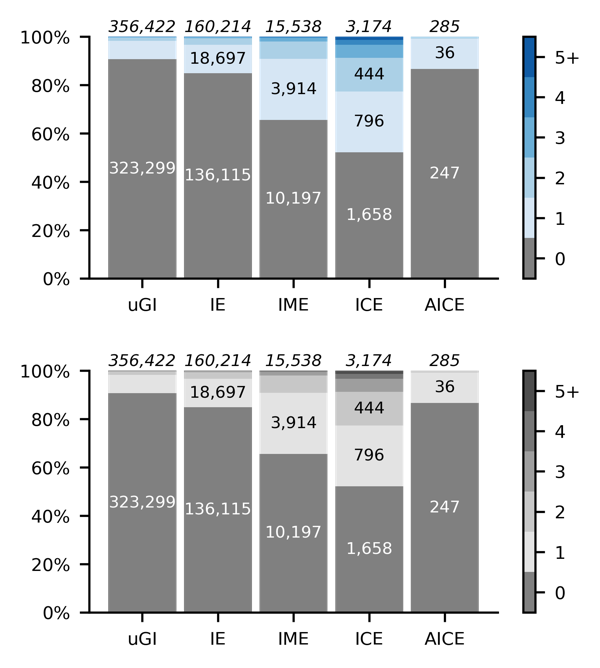

In [22]:
df = aggregate_format(
    ds.defensefinder_system_by_label,
    index="label",
).filter(pl.col("label") != "ψICE")
df = df.melt("label", variable_name="nsys", value_name="count").with_columns(
    pl.when(pl.col("nsys").cast(int) >= 5)
    .then("5+")
    .otherwise(pl.col("nsys").cast(str))
    .alias("nsys")
)
df = df.pivot(index="nsys", columns="label", values="count", aggregate_function="sum")
df = df.to_pandas().set_index("nsys").T
palette = {
    "0": "gray",
    **{
        str(i): c
        for i, c in zip(
            df.columns[1:],
            sns.color_palette("Blues", n_colors=len(df.columns) - 1),
        )
    },
}
with latex_size(double=True, width_prop=0.48, height=1.6):
    fig, ax = plt.subplots()
    propbarplot(
        df,
        legend=False,
        kind="bar",
        count_label=True,
        color=palette,
        ax=ax,
    )

    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "Custom cmap", list(palette.values()), len(palette)
    )
    cbar = fig.colorbar(
        cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=-0.5, vmax=len(palette) - 0.5), cmap=cmap
        ),
        ax=ax,
    )
    cbar.set_ticks(range(len(palette)))
    cbar.set_ticklabels(df.columns)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(False)
    ax.set_xlabel("")
    ax.set_ylim(0, 1)
fs.savefig(fig, "panel_A")


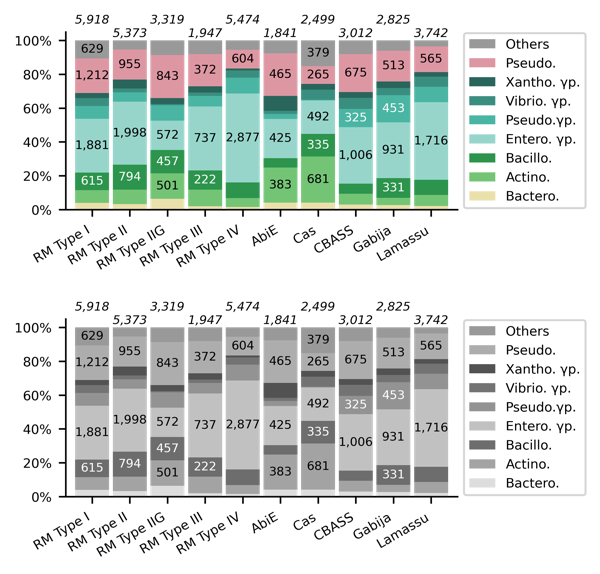

In [23]:
df = aggregate_format(
    ds.defensefinder_by_phylum, index="phylum", columns="defense_finder"
)
in_phy8 = pl.col("phylum").is_in(alias_or_name(format_data["phylum_8"]))
df_8 = df.filter(in_phy8)
others = df.filter(~in_phy8)
df = pl.concat(
    [df_8, others.sum(axis=0).with_columns(pl.lit("Others").alias("phylum"))],
    how="vertical",
)
selected_cols = sorted(
    [col for col in df.columns if col != "phylum"],
    key=lambda col: df[col].sum(),
    reverse=True,
)[:10]
df = df.select("phylum", *[c for c in df.columns if c in selected_cols])

colors = {
    info.get("alias", name): info.get("color")
    for name, info in format_data["phylum_8"].items()
}
order = pl.DataFrame(enumerate(colors.keys()), schema=["order", "phylum"])
df = order.select("phylum").join(df, on="phylum", how="left")

with latex_size(double=True, width_prop=0.5, height=1.6):
    fig, ax = plt.subplots()

    propbarplot(
        df.to_pandas().set_index("phylum").T,
        ax=ax,
        legend=False,
        kind="bar",
        barlabel=True,
        alternate=True,
        color=colors,
    )
    h, l = ax.get_legend_handles_labels()
    l = [abbr_phyl.get(txt, txt) for txt in l]
    leg = ax.legend(
        h[::-1], l[::-1],
        ncol=1,
        loc="center left",
        bbox_to_anchor=(1.0, 0.5),
    )
    # leg.set_in_layout(False)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    ax.grid(False)
    ax.set_xlabel("")
fs.savefig(fig, "panel_B")


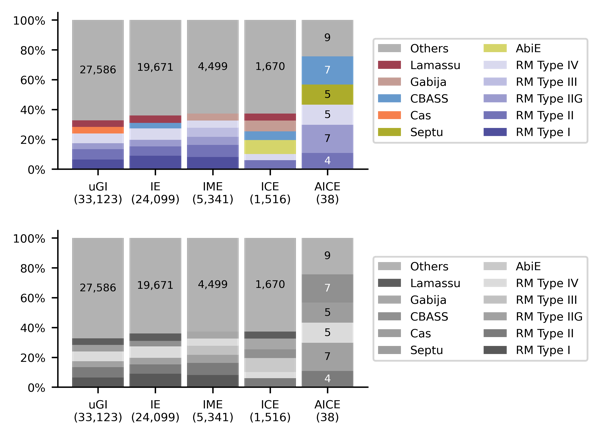

In [24]:
df = ds.defensefinder_by_label.melt(
    "label", variable_name="defense_finder", value_name="count"
)
df = df.filter(pl.col("label") != "psiICE")
ranked = pl.col("count") > pl.col("count").take(6)
df = (
    df.sort("count", descending=True)
    .groupby("label")
    .agg(
        pl.col("count").filter(ranked).append(pl.col("count").filter(~ranked).sum()),
        pl.col("defense_finder").filter(ranked).append(pl.lit("Others")),
    )
)

df = (
    df.explode("defense_finder", "count")
    .pivot(
        index="label", columns="defense_finder", values="count", aggregate_function=None
    )
    .fill_null(0)
)

df = aggregate_format(df, index="label", columns="defense_finder")
colors = {
    info.get("alias", name): info.get("color")
    for name, info in format_data["defense_finder"].items()
}
count = (
    (
        ds.defensefinder.select("index", pl.col("nsystems_dfinder").clip_max(1))
        .join(ds.labels, on="index")
        .groupby("label")
        .agg(pl.col(pl.NUMERIC_DTYPES).sum())
    )
    .to_pandas()
    .set_index("label")
    .squeeze()
    .to_dict()
)

with latex_size(double=True, width_prop=0.45, height=1.6):
    fig, ax = plt.subplots()

    propbarplot(
        df.to_pandas().set_index("label"),
        ax=ax,
        legend=False,
        kind="bar",
        barlabel=True,
        total_label=False,
        color=colors,
    )
    leg = ax.legend(
        *get_legend_hl(ax),
        ncol=2,
        loc="center left",
        bbox_to_anchor=(1.0, 0.5),
    )
    leg.set_in_layout(False)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_xticklabels(
        [
            f"{label.get_text()}\n({count[label.get_text()]:,})"
            for label in ax.get_xticklabels()
        ],
        rotation=0,
    )
    ax.grid(False)
    ax.set_xlabel("")

fs.savefig(fig, "panel_C", bbox_extra_artists=(leg,))


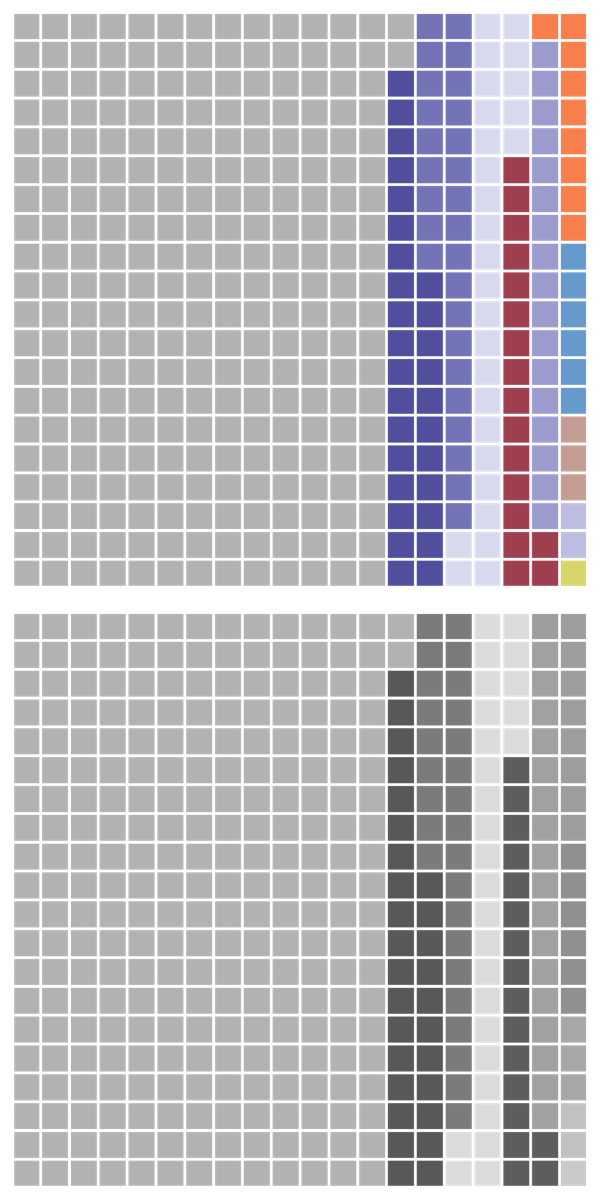

In [25]:
from pywaffle import Waffle

total = df.to_pandas().set_index("label").sum(axis=0).sort_values(ascending=False)
prop = (total / total.sum()).apply("{:.1%}".format)

with latex_size(double=True):
    fig = plt.figure(
        FigureClass=Waffle,
        rows=20,
        columns=20,
        values=total.to_numpy(),
        colors=[colors[col] for col in total.keys()],
        block_arranging_style="snake",
    )
fs.savefig(fig, "panel_D")

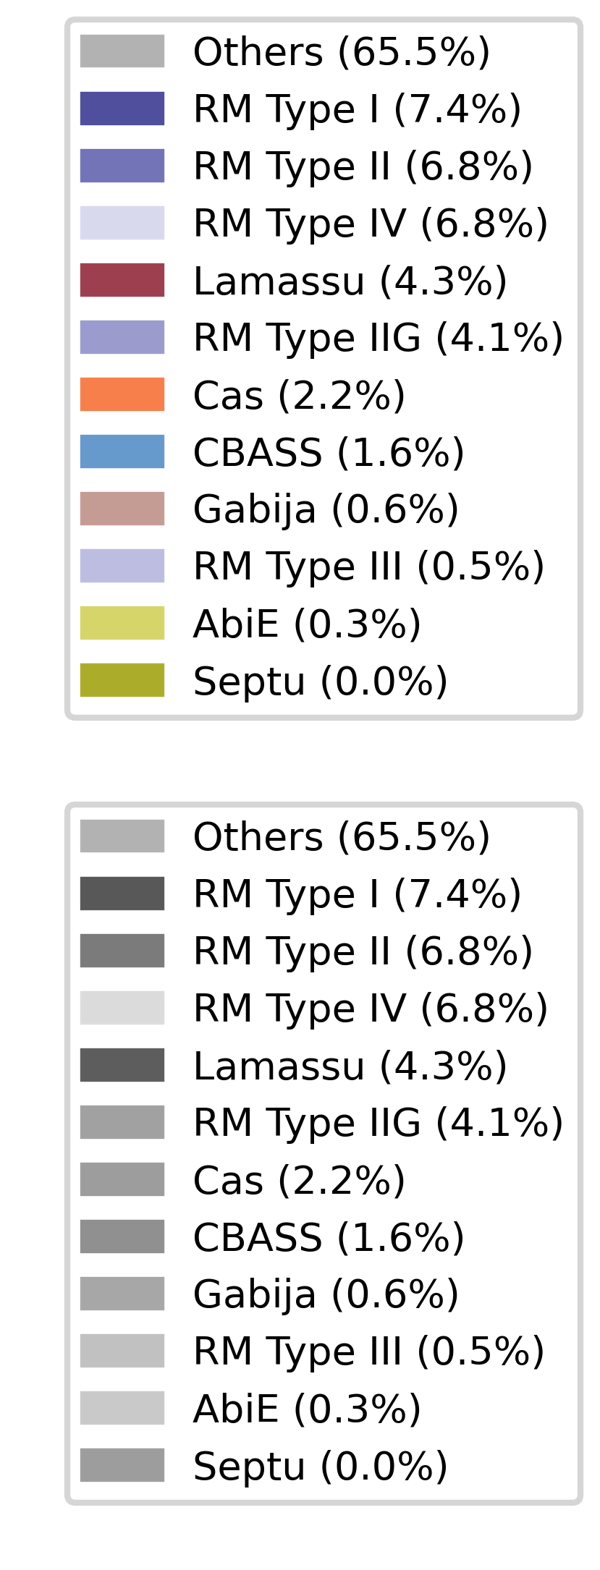

In [26]:
with latex_size():
    figlegend = plt.figure(figsize=(1, 1))
    handles = [
        mpatches.Patch(color=color, label=f"{key} ({prop[key]})")
        for (key, value), color in zip(
            total.iteritems(), [colors[col] for col in total.keys()]
        )
    ]
    figlegend.legend(handles=handles, ncol=1)
fs.savefig(figlegend, "panel_D_legend")
